In [32]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
from typing import Optional, Tuple
import math
import torch.utils.data as data
import torchvision
from matplotlib import pyplot as plt
import torch
import tqdm
from datetime import datetime
from tqdm.notebook import tqdm_notebook
from torch2jax import t2j

Setting some parameters

In [46]:
image_size = 28
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

Downloading MNIST from torchvision


In [65]:
# Set preprocess operations with channel reordering
MNIST_preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        # Convert from (C, H, W) to (H, W, C) format
        torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
])

# Download datasets with corrected preprocessing
train_dataset = torchvision.datasets.MNIST(
        root='data/MNIST',
        train=True,
        download=True,
        transform=MNIST_preprocess  # <-- Now includes channel reordering
)

# Split and create loaders (no changes needed here)
train_set, val_set = data.random_split(train_dataset, [50000, 10000])
test_set = torchvision.datasets.MNIST(
        root='data/MNIST',
        train=False,
        download=True,
        transform=MNIST_preprocess  # <-- Same corrected transform
)

# Data loaders remain unchanged
train_loader = data.DataLoader(dataset=train_set, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=128, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, batch_size=128, shuffle=False)

VisionTransformer with LayerNorm

In [11]:
class TransformerEncoderWithLayerNorm(nnx.Module):
    def __init__(
            self,
            hidden_size: int,
            mlp_dim: int,
            num_heads: int,
            dropout_rate: float = 0.0,
            *,
            rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:

        self.norm1 = nnx.LayerNorm(hidden_size, rngs=rngs)
        self.attn = nnx.MultiHeadAttention(
                num_heads=num_heads,
                in_features=hidden_size,
                dropout_rate=dropout_rate,
                broadcast_dropout=False,
                decode=False,
                deterministic=False,
                rngs=rngs,
        )
        self.norm2 = nnx.LayerNorm(hidden_size, rngs=rngs)

        self.mlp = nnx.Sequential(
                nnx.Linear(hidden_size, mlp_dim, rngs=rngs),
                nnx.gelu,
                nnx.Dropout(dropout_rate, rngs=rngs),
                nnx.Linear(mlp_dim, hidden_size, rngs=rngs),
                nnx.Dropout(dropout_rate, rngs=rngs),
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [12]:
class VisionTransformerWithLayerNorm(nnx.Module):

    def __init__(
            self,
            num_classes: int = 1000,
            in_channels: int = 3,
            img_size: int = 224,
            patch_size: int = 16,
            num_layers: int = 12,
            num_heads: int = 12,
            mlp_dim: int = 3072,
            hidden_size: int = 768,
            dropout_rate: float = 0.1,
            *,
            rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        # Patch and position embedding
        n_patches = (img_size // patch_size) ** 2
        self.patch_embeddings = nnx.Conv(
                in_channels,
                hidden_size,
                kernel_size=(patch_size, patch_size),
                strides=(patch_size, patch_size),
                padding="VALID",
                use_bias=True,
                rngs=rngs,
        )

        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        self.position_embeddings = nnx.Param(
                initializer(rngs.params(), (1, n_patches + 1, hidden_size), jnp.float32)
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

        self.cls_token = nnx.Param(jnp.zeros((1, 1, hidden_size)))

        # Transformer Encoder blocks
        self.encoder = nnx.Sequential(*[
                TransformerEncoderWithLayerNorm(hidden_size, mlp_dim, num_heads, dropout_rate, rngs=rngs)
                for i in range(num_layers)
        ])
        self.final_norm = nnx.LayerNorm(hidden_size, rngs=rngs)

        # Classification head
        self.classifier = nnx.Linear(hidden_size, num_classes, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        # Patch and position embedding
        patches = self.patch_embeddings(x)
        batch_size = patches.shape[0]
        patches = patches.reshape(batch_size, -1, patches.shape[-1])

        cls_token = jnp.tile(self.cls_token, [batch_size, 1, 1])
        x = jnp.concat([cls_token, patches], axis=1)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)

        # Encoder blocks
        x = self.encoder(embeddings)
        x = self.final_norm(x)

        # fetch the first token
        x = x[:, 0]

        # Classification
        return self.classifier(x)

Initializing the model

In [66]:
model_with_layer_norm = VisionTransformerWithLayerNorm(num_classes=10, img_size=28, in_channels= 1)

In [69]:
learning_rate = 0.005
momentum = 0.9

optimizer_with_layer_norm = nnx.Optimizer(model_with_layer_norm, optax.adamw(learning_rate, momentum))



 Define training step functions

In [70]:
def compute_loss(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels)
    return jnp.mean(loss)

In [71]:
@nnx.jit
def train_step(model, optimizer, inputs, outputs):
    def loss_fn(model, train_input, target_input):
        logits = model(train_input)
        loss = compute_loss(logits, target_input)
        return loss

    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, inputs, outputs)
    optimizer.update(grads)
    return loss

In [72]:
@nnx.jit
def eval_step(model, inputs, outputs, eval_metrics):
    logits = model(inputs)
    loss = compute_loss(logits, outputs)

    eval_metrics.update(
            loss=loss,
            logits=logits,
            labels=outputs,
    )

In [78]:
eval_metrics = nnx.MultiMetric(
        loss=nnx.metrics.Average('loss'),
        accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
        "train_loss": [],
}

eval_metrics_history = {
        "test_loss": [],
        "test_accuracy": [],
}

In [79]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(train_loader) // 32

In [80]:
def train_one_epoch(model, optimizer, num_epochs,epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
            desc=f"[train] epoch: {epoch}/{num_epochs}, ",
            total=train_total_steps,
            bar_format=bar_format,
            leave=True,
    ) as pbar:
        for input_batch, target_batch in train_loader:
            input_batch, target_batch = t2j(input_batch), t2j(target_batch)
            loss = train_step(model, optimizer, input_batch, target_batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


In [81]:
def evaluate_model(model, num_epochs, epoch):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    eval_metrics.reset()  # Reset the eval metrics
    for val_input, val_target in val_loader:
        val_input, val_target = t2j(val_input), t2j(val_target)
        eval_step(model, val_input, val_target, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

In [ ]:
# Model with LayerNorm
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model_with_layer_norm, optimizer_with_layer_norm, num_epochs, epoch)
    evaluate_model(model_with_layer_norm, num_epochs, epoch)

[train] epoch: 0/10, [20/?], loss=2.61 [00:14<00:00] 

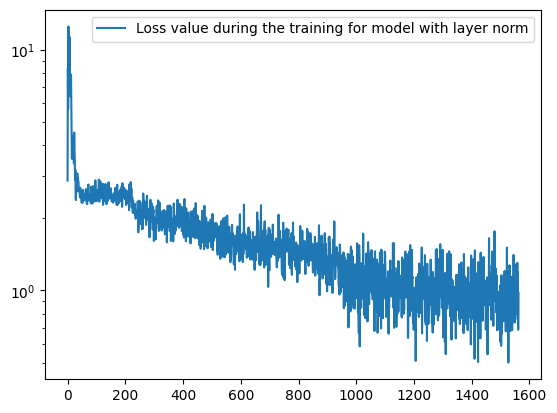

In [64]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_history["train_loss"], label="Loss value during the training for model with layer norm")
plt.yscale('log')
plt.legend()

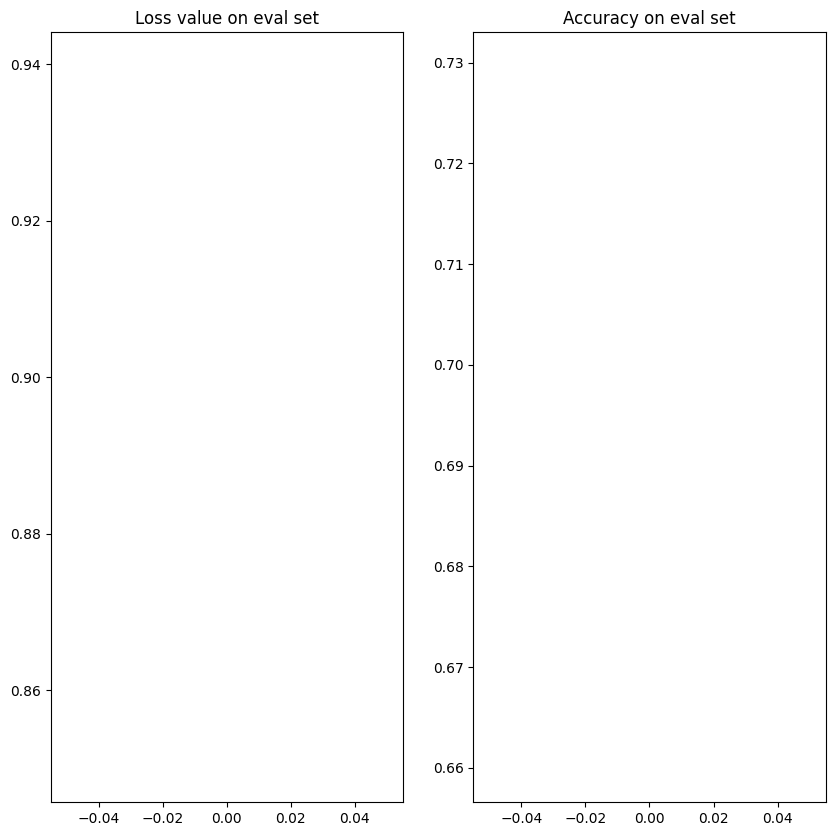

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on eval set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on eval set")
axs[1].plot(eval_metrics_history["test_accuracy"])